### Simple RNN based sentiment analysis solution
- Demo the use of Bi-directional LSTM architecture
- Demo the use of LSTM (one direction) architecture
- Demo the use of GRU architecture

References:
- [Inspired by Kaggle kernel by arunmohan_003](https://www.kaggle.com/code/arunmohan003/sentiment-analysis-using-lstm-pytorch)
- [Inspired by Ameya Harshad Chaudhari blog](https://github.com/ameya123ch/Finanical_news_Sentiment_analysis/blob/main/financial_news_sentiment_analysis.ipynb)

### Install required libraries

In [140]:
! pip install torchviz
! pip install nltk

#### Imports

In [141]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import torch
from torchviz import make_dot
import torch.nn as nn
import torch.nn.functional as F
import torch.optim.lr_scheduler as lr_scheduler
from nltk.corpus import stopwords
from collections import Counter
import string
import re
import seaborn as sns
from tqdm import tqdm
import matplotlib.pyplot as plt
from torch.utils.data import TensorDataset, DataLoader
from sklearn.model_selection import train_test_split
import tqdm
import logging
from typing import List, Tuple, Dict, Any
from sklearn.metrics import accuracy_score, classification_report
import seaborn as sns
from sklearn.metrics import confusion_matrix
import pickle as pl

### Setup the logger

In [142]:
logger = logging.getLogger('my_logger')
logging.basicConfig(format='%(asctime)s - %(message)s',
                    level=logging.INFO,
                    force=True)



##### Specify compute device

In [143]:
def get_compute_device() -> torch.device:
  """
  Get the compute device
  returns: device (torch.device): compute device
  """
  is_cuda = torch.cuda.is_available()
  # If we have a GPU available, we'll set our device to GPU. We'll use this device variable later in our code.
  if is_cuda:
      device = torch.device("cuda")
      print("GPU is available")
  else:
      device = torch.device("cpu")
      print("GPU not available, CPU used")
  return device

### Global configs

In [144]:
DATA_PATH = "../data/india_financial_news_sentiment.csv"
MODEL_PATH = "../models/financial_news_rnn_sentiment_model.pt"
RESULTS_PATH = "../results/financial_news_rnn_sentiment_results.pl"
REVIEW_NAME = "review"
SENTIMENT_NAME = "sentiment"
POSITIVE_NAME = "positive"
TEST_PARTITION_SIZE = 0.05
VALIDATION_PARTITION_SIZE = 0.30
RANDOM_SEED = 100
N_MAX_CORPUS_WORDS = 1000
SENTENCE_LENGHT_LIMIT = 25
LINE_DIVIDER = '*' * 50
BATCH_SIZE = 128
DROP_PROBABILITY = 0.5

# LSTM network configs
DEVICE = get_compute_device()
N_LAYERS = 2
EMBEDDING_DIM = 64
OUTPUT_DIM = 1
HIDDEN_DIM = 256
VOCAB_SIZE = N_MAX_CORPUS_WORDS + 1
LEARNING_RATE = 0.001
SCHEDULER_START_FACTOR = 1
SCHEDULER_END_FACTOR = 0.5
SCHEDULER_ITERATIONS = 30
N_EPOCHS = 5
GRADIENT_CLIP = 5
IS_USE_PRETRAINED_MODEL = False



GPU is available


#### Include NLTK data downloads

In [145]:
import nltk
nltk.download('punkt_tab')
nltk.download('stopwords')

[nltk_data] Downloading package punkt_tab to /home/ubuntu/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!
[nltk_data] Downloading package stopwords to /home/ubuntu/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

#### 6. Exploratory Data Analysis
- 1.1 Display the Financial News Review dataset
- 1.2 Dataset stats
- 1.3 Dataset info
- 1.4 Partition dataset
- 1.5 Check class balance (distribution)

In [146]:
def explore_data(data_path: str=DATA_PATH):
    """
    param data_path (str): path to the data file
    returns: data_df (pd.DataFrame): data frame containing the data
    returns: data_stats (pd.DataFrame): statistics of the data
    returns: data_info (pd.DataFrame): information about the data
    """
    data_df = pd.read_csv(data_path, encoding="utf8").dropna()
    data_stats = data_df.describe()
    return data_df, data_stats

def partition_dataset(data_df: pd.DataFrame):
    """
    param data_df (pd.DataFrame): data frame containing the data
    returns: X_train_in (np.array): training data
    returns: X_val_in (np.array): validation data
    returns: X_test_in (np.array): test data
    returns: y_train_in (np.array): training labels
    returns: y_val_in (np.array): validation labels
    returns: y_test_in (np.array): test labels
    """
    X,y = data_df[REVIEW_NAME].values, data_df[SENTIMENT_NAME].values
    X_temp, X_test_in, y_temp, y_test_in = train_test_split(
        X,
        y,
        test_size=TEST_PARTITION_SIZE,
        random_state=RANDOM_SEED,
        stratify=y)
    X_train_in, X_val_in, y_train_in, y_val_in = train_test_split(
        X_temp,
        y_temp,
        test_size=VALIDATION_PARTITION_SIZE,
        random_state=RANDOM_SEED,
        stratify=y_temp)

    print(f'shape of train data is {X_train_in.shape}')
    print(f'shape of test data is {X_val_in.shape}')
    return X_train_in, X_val_in, X_test_in, y_train_in, y_val_in, y_test_in


def plot_class_distribution(y_train_df: pd.DataFrame):
    """
    param y_train_df: Training labels
    returns: None
    """
    dd = pd.Series(y_train_df).value_counts()
    total_count = dd.sum()
    dd_percentage = dd.apply(lambda x: 100.0 * x / total_count)
    sns.barplot(x=np.array(['negative','positive']),y=dd.values)
    plt.title('Class distribution of training data')
    plt.xlabel('Class')
    plt.ylabel('Count')
    print(f"Class distributions (%):\n{dd_percentage}")
    plt.show()

In [147]:
data_df, data_stats = explore_data()

##### 1.1 Display the Financial News Review dataset

In [148]:
data_df.head()

,review,sentiment
0,Eliminating shadow economy to have positive im...,positive
1,Two Chinese companies hit roadblock with India...,negative
2,SoftBank India Vision gets new $100,positive
3,Nissan halts joint development of luxury cars ...,negative
4,Despite challenges Rajasthan continues to prog...,positive


##### 1.2 Dataset stats

In [149]:
data_stats

,review,sentiment
count,200500,200500
unique,200288,2
top,Rupee weakens against US dollar,negative
freq,3,108118


##### 1.3 Dataset info

In [150]:
data_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 200500 entries, 0 to 200499
Data columns (total 2 columns):
 #   Column     Non-Null Count   Dtype 
---  ------     --------------   ----- 
 0   review     200500 non-null  object
 1   sentiment  200500 non-null  object
dtypes: object(2)
memory usage: 3.1+ MB


##### 1.4 Partition dataset

In [151]:
X_train, X_val, X_test, y_train, y_val, y_test = partition_dataset(data_df)

shape of train data is (133332,)
shape of test data is (57143,)


##### 1.5 Check class balance (distribution)

Class distributions (%):
negative    53.924039
positive    46.075961
Name: count, dtype: float64


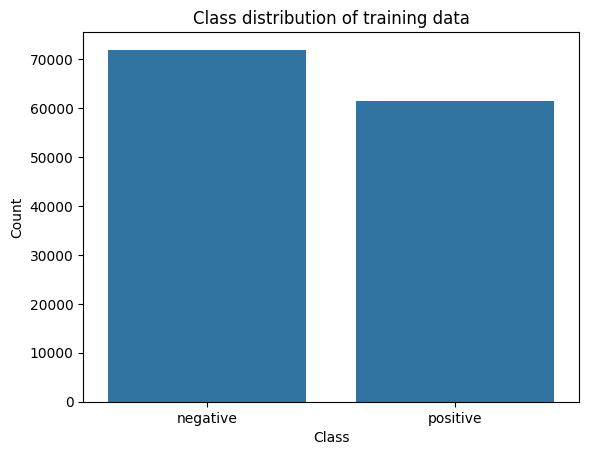

In [152]:
plot_class_distribution(y_train)

##


#### 7. Data Preparation - Tokenization considerations
- Normalize the news reviews text (corpus) with Regex:
  - Remove all non-word characters (everything except numbers and letters)
  - Replace all runs of whitespaces with no space
  - Replace digits with no space
  - Remove any occurence of "stop words"

- Create a vocabulary of the news review corpus:
  - Compute a unique list of words from the corpus
  - Compute the frequency of words in the corpus
    - Create a one-hot encoding i.e. a dictionary with key is word and the value is a unique index

In [153]:
def preprocess_token(token: str) -> str:
  """
  Preprocess a single token
  param token (str): token to be preprocessed
  returns: new_token (str): preprocessed token
  """
  # Remove all non-word characters (everything except numbers and letters)
  new_token = re.sub(r"[^\w\s]", '', token)
  # Replace all runs of whitespaces with no space
  new_token = re.sub(r"\s+", '', new_token)
  # replace digits with no space
  new_token = re.sub(r"\d", '', new_token)
  return new_token

def create_unique_word_list(documents: List[str]) -> List[str]:
  """
  Create a unique word list from a list of documents
  param documents (List[str]): list of documents
  returns: word_list (List[str]): list of unique words
  """
  word_list = []
  stop_words = set(stopwords.words('english'))
  try:
    for sent in documents:
        sent_new = str(sent)
        for word in sent_new.lower().split():
            word = preprocess_token(word)
            if word not in stop_words and word != '':
                word_list.append(word)
  except:
    print(f"error word is: {word}")
  return word_list

def create_corpus_vocabulary_(
    unique_word_list: List[str],
    n_max_words: int=N_MAX_CORPUS_WORDS) -> Dict[str, int]:
  """
  Create a corpus vocabulary from a list of unique words
  param unique_word_list (List[str]): list of unique words
  param n_max_words (int): maximum number of words to be included in the vocabulary
  returns: corpus_vocabulary (Dict[str, int]): dictionary of unique words
  """
  corpus = Counter(unique_word_list)
  # sorting on the basis of most common words
  corpus_ = sorted(corpus,key=corpus.get,reverse=True)[:n_max_words]
  # creating a dict
  vocabulary = {w:i+1 for i,w in enumerate(corpus_)}
  return vocabulary

def create_corpus_vocabulary(corpus: List[str]) -> Dict[str, int]:
  """
  Create a corpus vocabulary from a list of documents
  param corpus (List[str]): list of documents
  returns: corpus_vocabulary (Dict[str, int]): dictionary of unique words and their indices
  """
  unique_word_list = create_unique_word_list(corpus)
  corpus_vocabulary = create_corpus_vocabulary_(unique_word_list)
  return corpus_vocabulary

def tokenize_corpus(
    corpus: List[str],
    vocabulary: Dict[str, int]) -> List[List[int]]:
  """
  Tokenize a list of documents
  param corpus (List[str]): list of documents
  param vocabulary (Dict[str, int]): dictionary of unique words and their indices
  returns: tokenized_corpus (List[List[int]]): list of tokenized documents
  """
  tokenized_corpus = []
  for sent in corpus:
    sent_new = str(sent)
    tokenized_corpus.append([vocabulary[preprocess_token(word)] for word in sent_new.lower().split()
                              if preprocess_token(word) in vocabulary.keys()])
  return tokenized_corpus

def preprocess_dataset(
    X_train: np.array,
    X_val: np.array,
    y_train: np.array,
    y_val: np.array
    ) -> Tuple[np.array, np.array, np.array, np.array, Dict[str, int]]:
    """
    Preprocess the dataset
    param X_train (np.array): training data
    param X_val (np.array): validation data
    param y_train (np.array): training labels
    param y_val (np.array): validation labels
    returns: X_train_tokenized_ (np.array): tokenized training data
    returns: y_train_ (np.array): training labels
    returns: X_val_tokenized_ (np.array): tokenized validation data
    returns: y_val_ (np.array): validation labels
    returns: vocabulary (Dict[str, int]): dictionary of unique words and their indices
    """
    vocabulary = create_corpus_vocabulary(corpus=X_train)
    X_train_tokenized = tokenize_corpus(X_train, vocabulary)
    X_val_tokenized = tokenize_corpus(X_val, vocabulary)
    encoded_y_train = [1 if label == POSITIVE_NAME else 0 for label in y_train]
    encoded_y_val = [1 if label == POSITIVE_NAME else 0 for label in y_val]

    X_train_tokenized_ = np.array(X_train_tokenized, dtype=object)
    y_train_ = np.array(encoded_y_train)
    X_val_tokenized_ = np.array(X_val_tokenized, dtype=object)
    y_val_ = np.array(encoded_y_val)
    return X_train_tokenized_,y_train_,X_val_tokenized_,y_val_,vocabulary

def pad_corpus_sentences(
    sentences: List[List[int]],
    sentence_length_limit=SENTENCE_LENGHT_LIMIT):
    """
    Pad a list of sentences to a specified length
    param sentences (List[List[int]]): list of sentences
    param sentence_length_limit (int): length of the sentences
    returns: features (np.array): padded sentences
    """
    features = np.zeros((len(sentences), sentence_length_limit),dtype=int)
    for ii, review in enumerate(sentences):
        if len(review) != 0:
            features[ii, -len(review):] = np.array(review)[:sentence_length_limit]
    return features

def get_stats_review_length(corpus: np.array) -> pd.DataFrame:
  """
  Get the statistics of the review length
  param corpus (np.array): array of token indicies
  returns: None
  """
  review_length = [len(i) for i in corpus]
  pd.Series(review_length).hist()
  plt.show()
  return pd.Series(review_length).describe().to_frame(name='Stats')

def create_tensor_loaders(
    X_train_pad,
    y_train_,
    X_val_pad,
    y_val_) -> DataLoader:
  """
  Create tensor loaders for the LSTM network/model
  param X_train_padded (np.array): padded training data
  param y_train_ (np.array): training labels
  param X_val_padded (np.array): padded validation data
  param y_val_ (np.array): validation labels
  returns: train_loader (DataLoader): training data loader
  returns: valid_loader (DataLoader): validation data loader
  """
  # create Tensor datasets
  # train_data = TensorDataset(
  #     torch.from_numpy(np.array(X_train_pad, dtype=np.int32)),
  #     torch.from_numpy(np.array(y_train_, dtype=np.int32)))
  # valid_data = TensorDataset(
  #     torch.from_numpy(np.array(X_val_pad, dtype=np.int32)),
  #     torch.from_numpy(np.array(y_val_, dtype=np.int32)))

  train_data = TensorDataset(
      torch.from_numpy(X_train_pad),
      torch.from_numpy(np.array(y_train_, dtype=np.float32)))
  valid_data = TensorDataset(
      torch.from_numpy(X_val_pad),
      torch.from_numpy(np.array(y_val_, dtype=np.float32)))


  # create dataloaders - make sure to SHUFFLE your data
  train_loader = DataLoader(train_data, shuffle=True, batch_size=BATCH_SIZE, drop_last=True)
  valid_loader = DataLoader(valid_data, shuffle=True, batch_size=BATCH_SIZE, drop_last=True)
  return train_loader, valid_loader



In [154]:
X_train_tokenized_, y_train_, X_val_tokenized_, y_val_, vocabulary = preprocess_dataset(X_train, X_val, y_train, y_val)

X_train_padded = pad_corpus_sentences(X_train_tokenized_)
X_val_padded = pad_corpus_sentences(X_val_tokenized_)

train_loader, valid_loader = create_tensor_loaders(X_train_padded, y_train_, X_val_padded, y_val_)


##### Display the first 10 rows of the corpus vocabulary

In [155]:
print(f"vocabulary:\n{list(vocabulary.items())[:10]}")

vocabulary:
[('india', 1), ('market', 2), ('rs', 3), ('us', 4), ('says', 5), ('stocks', 6), ('sensex', 7), ('nifty', 8), ('china', 9), ('growth', 10)]


##### Display sample of tokenized corpus text and encoded labels

In [156]:
print(f"X_train_tokenized sample:\n{X_train_tokenized_[:5]}")
print(f"{LINE_DIVIDER}\n")
print(f"y_train_ sample:\n{y_train_[:5]}")
print(f"{LINE_DIVIDER}\n")
print(f"X_val_tokenized sample:\n{X_val_tokenized_[:5]}")
print(f"{LINE_DIVIDER}\n")
print(f"y_val_ sample:\n{y_val_[:5]}")
print(f"{LINE_DIVIDER}\n")


X_train_tokenized sample:
[list([509, 6, 2, 153])
 list([1, 180, 696, 15, 173, 426, 190, 120, 259, 241, 112, 5, 517, 571, 443, 481])
 list([351, 114, 3, 25, 599, 491, 91, 156, 21])
 list([164, 95, 16, 77, 320, 199, 127])
 list([326, 95, 36, 326, 109, 3, 874])]
**************************************************

y_train_ sample:
[0 0 0 0 0]
**************************************************

X_val_tokenized sample:
[list([209, 25, 57]) list([183, 59, 504, 302, 243, 87, 508, 720, 761])
 list([352, 336, 133, 54, 417, 285, 63]) list([201, 419, 548])
 list([342, 123, 636, 446, 353])]
**************************************************

y_val_ sample:
[1 0 0 0 1]
**************************************************



##### Analyse the review length statistics

##### Display a sample of the padded tokenized text corpus

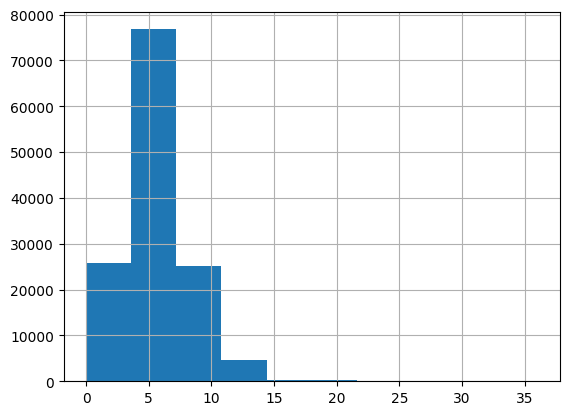

,Stats
count,133332.000000
mean,5.763980
std,2.721359
min,0.000000
25%,4.000000
50%,6.000000
75%,7.000000
max,36.000000


In [157]:
get_stats_review_length(X_train_tokenized_)

Observations : <br>a) Mean review length = around 6.<br> b) minimum length of reviews is 0.<br>c)There are quite a few reviews that are extremely long, we can manually investigate them to check whether we need to include or exclude them from our analysis.

In [158]:
print(f"X_train_padded sample:\n{X_train_padded[:5]}")
print(f"{LINE_DIVIDER}\n")
print(f"X_val_padded sample:\n{X_val_padded[:5]}")
print(f"{LINE_DIVIDER}\n")

X_train_padded sample:
[[  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0 509   6   2 153]
 [  0   0   0   0   0   0   0   0   0   1 180 696  15 173 426 190 120 259
  241 112   5 517 571 443 481]
 [  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0 351 114
    3  25 599 491  91 156  21]
 [  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
  164  95  16  77 320 199 127]
 [  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
  326  95  36 326 109   3 874]]
**************************************************

X_val_padded sample:
[[  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0 209  25  57]
 [  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0 183  59
  504 302 243  87 508 720 761]
 [  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
  352 336 133  54 417 285  63]
 [  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0  

##### Batch and create tensors to load the data into the LSTM network
- Data will be loaded into the LSTM newtork in batches of 128 for eadh sentence lenght of 25
- We are also going to create tensor loaders for the LSTM network/model

In [159]:
data_iter = iter(train_loader)
features, labels = next(data_iter)

print('Sample input size: ', features.size()) # batch_size, seq_length
print('Sample input: \n', features)
print('Sample input: \n', labels)


Sample input size:  torch.Size([128, 25])
Sample input: 
 tensor([[  0,   0,   0,  ...,  77, 170,  58],
        [  0,   0,   0,  ...,   0, 297, 107],
        [  0,   0,   0,  ...,  88,  25, 349],
        ...,
        [  0,   0,   0,  ...,   0, 440,  74],
        [  0,   0,   0,  ..., 132, 466,   5],
        [  0,   0,   0,  ..., 840, 263,  23]])
Sample input: 
 tensor([0., 1., 0., 0., 0., 1., 1., 0., 1., 0., 0., 1., 0., 0., 0., 0., 0., 1.,
        1., 1., 0., 0., 1., 1., 0., 0., 0., 1., 0., 1., 1., 1., 0., 1., 1., 1.,
        0., 1., 0., 1., 0., 0., 0., 0., 0., 0., 1., 1., 0., 1., 0., 1., 1., 0.,
        0., 0., 0., 1., 0., 0., 0., 1., 0., 1., 1., 0., 1., 0., 1., 1., 0., 1.,
        1., 0., 0., 0., 0., 0., 0., 0., 1., 1., 0., 1., 1., 1., 1., 1., 1., 0.,
        1., 0., 0., 1., 0., 1., 1., 1., 0., 1., 0., 0., 0., 0., 1., 0., 1., 1.,
        0., 1., 1., 1., 1., 1., 0., 0., 1., 1., 0., 1., 0., 1., 1., 0., 0., 0.,
        1., 0.])


##### 8. Code walk through of the LSTM network/model implementation
- 8.1 Buuld the LSTM model class
- 8.2 Instantiate the LTSM model
- 8.3 Visualize the LSTM mode
- 8.4 Helper functions

##### 8.1 Build the LSTM model class
- We are going to use multi-layer LSTM network
- We will need to add an embedding layer because:
  - there are less words in our vocabulary
  - the current one-hot encoding we have is massively inefficient
  - the embedding layer will facilitate an embedding that is learnt during the training of the network itself
  - another option is to use a pre-trained word-embeddings
- The network also uses the final hidden state from the previous batch as the initial state for the current batch, allowing the model to learn dependencies that span across batches:
  - this can significantly improve memory use and performance

In [160]:
class SentimentLSTM(nn.Module):
    """
    The LSTM model that will be used to perform Sentiment analysis.
    """
    def __init__(
        self,
        no_layers: int,
        vocab_size: int,
        hidden_dim: int,
        output_dim: int,
        embedding_dim: int,
        drop_prob: float=DROP_PROBABILITY,
        device: torch.device=DEVICE):
      """
      Constructor of the SentimentLSTM class
      param no_layers (int): number of layers
      param vocab_size (int): vocabulary size
      param hidden_dim (int): hidden dimension
      param embedding_dim (int): embedding dimension
      param drop_prob (float): dropout probability
      """
      super(SentimentLSTM, self).__init__()
      self.device = device
      self.output_dim = output_dim
      self.hidden_dim = hidden_dim

      self.no_layers = no_layers
      self.vocab_size = vocab_size

      # embedding and LSTM layers
      self.embedding = nn.Embedding(vocab_size, embedding_dim)

      #lstm
      self.lstm = nn.LSTM(input_size=embedding_dim,hidden_size=self.hidden_dim,
                          num_layers=no_layers, batch_first=True)


      # dropout layer
      self.dropout = nn.Dropout(drop_prob)  # 0.3

      # linear and sigmoid layer
      self.fc = nn.Linear(self.hidden_dim, output_dim)
      self.sig = nn.Sigmoid()

    def forward(
        self,
        x: torch.Tensor,
        hidden: torch.Tensor
        ):
      """
      Forward pass of the network
      param x (torch.Tensor): input tensor
      param hidden (torch.Tensor): hidden tensor
      returns: sig_out (torch.Tensor): output tensor
      returns: hidden (torch.Tensor): hidden tensor
      """
      batch_size = x.size(0)
      # embeddings and lstm_out
      embeds = self.embedding(x)  # shape: B x S x Feature   since batch = True

      lstm_out, hidden = self.lstm(embeds, hidden)

      lstm_out = lstm_out.contiguous().view(-1, self.hidden_dim)

      # dropout and fully connected layer
      out = self.dropout(lstm_out)
      out = self.fc(out)

      # sigmoid function
      sig_out = self.sig(out)

      # reshape to be batch_size first
      sig_out = sig_out.view(batch_size, -1)

      sig_out = sig_out[:, -1] # get last batch of labels

      # return last sigmoid output and hidden state
      return sig_out, hidden

    def init_hidden(
      self,
      batch_size: int):
      """
      Initializes hidden state
      param batch_size (int): batch size
      returns: None
      """
      # Create two new tensors with sizes n_layers x batch_size x hidden_dim,
      # initialized to zero, for hidden state and cell state of LSTM
      h0 = torch.zeros((self.no_layers,batch_size,self.hidden_dim)).to(self.device)
      c0 = torch.zeros((self.no_layers,batch_size,self.hidden_dim)).to(self.device)
      hidden = (h0,c0)
      return hidden


##### 8.2 Instantiate the LTSM model

In [161]:
lstm_model = SentimentLSTM(
    no_layers=N_LAYERS,
    vocab_size=VOCAB_SIZE,
    hidden_dim=HIDDEN_DIM,
    output_dim=OUTPUT_DIM,
    embedding_dim=EMBEDDING_DIM,
    drop_prob=DROP_PROBABILITY)
lstm_model.to(DEVICE)


SentimentLSTM(
  (embedding): Embedding(1001, 64)
  (lstm): LSTM(64, 256, num_layers=2, batch_first=True)
  (dropout): Dropout(p=0.5, inplace=False)
  (fc): Linear(in_features=256, out_features=1, bias=True)
  (sig): Sigmoid()
)

##### 8.3 Visualize LSTM model

In [162]:
def visualize_lstm_model(lstm_model: SentimentLSTM, inputs: torch.Tensor):
  """
  Visualize the LSTM model
  param lstm_model (SentimentLSTM): LSTM model
  returns: None
  """
  h = lstm_model.init_hidden(BATCH_SIZE)
  output,h = lstm_model(inputs,h)
  dot = make_dot(output, params=dict(lstm_model.named_parameters()))
  dot.render("lstm_model", format="png")

##### 8.4 Helper functions

In [163]:
def acc(pred,label):
    pred = torch.round(pred.squeeze())
    return torch.sum(pred == label.squeeze()).item()

##### 9. Code walk through of the Sentiment Analysis solution

- 9.1 SentimentClassifier class structure
- 9.2 Instantiate and run the train-validation cycles
- 9.3 Analyse the model performance
- 9.4 Use the trained model to make predictions on unseen data


##### 9.1 SentimentClassifier class structure

In [164]:
class SentimentClassifier:
  """
  Sentiment Classifier class
  """
  def __init__(
      self,
      train_loader: DataLoader,
      valid_loader: DataLoader,
      lstm_model: SentimentLSTM,
      learning_rate: float=LEARNING_RATE,
      scheduler_start_factor = SCHEDULER_START_FACTOR,
      scheduler_end_factor = SCHEDULER_END_FACTOR,
      scheduler_total_iters = SCHEDULER_ITERATIONS,
      gradient_clip = GRADIENT_CLIP,
      epochs = N_EPOCHS,
      batch_size = BATCH_SIZE,
      device = DEVICE
    ):
    """
    Constructor of the SentimentClassifier class
    """
    self.train_loader = train_loader
    self.valid_loader = valid_loader
    self.lstm_model = lstm_model
    self.learning_rate = learning_rate
    self.epochs = epochs
    self.gradient_clip = gradient_clip
    self.batch_size = batch_size
    self.device = device
    self.criterion = nn.BCELoss()
    self.optimizer = torch.optim.Adam(self.lstm_model.parameters(), lr=self.learning_rate)
    self.scheduler = lr_scheduler.LinearLR(
      self.optimizer,
      start_factor=scheduler_start_factor,
      end_factor=scheduler_end_factor,
      total_iters=scheduler_total_iters)

    self.epoch_tr_loss, self.epoch_vl_loss = [],[]
    self.epoch_tr_acc, self.epoch_vl_acc = [],[]
    self.valid_expected_labels, self.valid_predicted_labels = [],[]


  def compute_accuracy(
      self,
      prediction: torch.Tensor,
      label: torch.Tensor) -> torch.Tensor:
      """
      Compute the accuracy of the prediction
      param prediction (torch.Tensor): prediction
      param label (torch.Tensor): label
      returns: torch.Tensor: accuracy
      """
      pred = torch.round(prediction.squeeze())
      return torch.sum(prediction == label.squeeze()).item()

  def run_train_validation_loop(self):
    """
    Run the train validation loop
    """
    valid_loss_min = np.inf

    for epoch in range(self.epochs):
        train_losses = []
        train_acc = 0.0
        self.lstm_model.train()

        # initialize hidden state
        h = self.lstm_model.init_hidden(self.batch_size)
        for inputs, labels in self.train_loader:

            inputs, labels = inputs.to(self.device), labels.to(self.device)

            # Creating new variables for the hidden state, otherwise
            # we'd backprop through the entire training history
            h = tuple([each.data for each in h])

            self.lstm_model.zero_grad()
            output,h = self.lstm_model(inputs,h)

            # calculate the loss and perform backprop
            loss = self.criterion(output.squeeze(), labels.float())
            loss.backward()
            train_losses.append(loss.item())

            # calculating accuracy
            # accuracy = self.compute_accuracy(output, labels.float())
            accuracy = acc(output, labels)
            train_acc += accuracy

            #`clip_grad_norm` helps prevent the exploding gradient problem in RNNs / LSTMs.
            nn.utils.clip_grad_norm_(self.lstm_model.parameters(), self.gradient_clip)

            self.optimizer.step()

        val_h = self.lstm_model.init_hidden(self.batch_size)
        val_losses = []

        val_losses_total = 0
        val_acc = 0.0
        self.lstm_model.eval()
        for inputs, labels in self.valid_loader:
            val_h = tuple([each.data for each in val_h])

            inputs, labels = inputs.to(self.device), labels.to(self.device)

            output, val_h = self.lstm_model(inputs, val_h)
            val_loss = self.criterion(output.squeeze(), labels.float())

            labels_as_list = labels.cpu().numpy().tolist()
            self.valid_expected_labels.extend(labels_as_list)
            output_as_list = output.squeeze().cpu().detach().numpy().tolist()
            predicted_labels = [1.0 if item > 0.5 else 0.0 for item in output_as_list]
            self.valid_predicted_labels.extend(predicted_labels)

            val_losses.append(val_loss.item())
            val_losses_total += val_loss.item()

            # accuracy = self.compute_accuracy(output,labels)
            accuracy = acc(output, labels)
            val_acc += accuracy

        # Modify the learing rate scheduler
        val_loss_avg = val_losses_total/len(self.valid_loader)
        before_lr = self.optimizer.param_groups[0]["lr"]
        self.scheduler.step()
        after_lr = self.optimizer.param_groups[0]["lr"]
        print("Epoch %d: SGD lr %.4f -> %.4f" % (epoch, before_lr, after_lr))

        epoch_train_loss = np.mean(train_losses)
        epoch_val_loss = np.mean(val_losses)
        epoch_train_acc = train_acc/len(self.train_loader.dataset)
        epoch_val_acc = val_acc/len(self.valid_loader.dataset)
        self.epoch_tr_loss.append(epoch_train_loss)
        self.epoch_vl_loss.append(epoch_val_loss)
        self.epoch_tr_acc.append(epoch_train_acc)
        self.epoch_vl_acc.append(epoch_val_acc)
        print(f'Epoch {epoch+1}')
        print(f'train_loss : {epoch_train_loss} val_loss : {epoch_val_loss}')
        print(f'train_accuracy : {epoch_train_acc*100} val_accuracy : {epoch_val_acc*100}')
        if epoch_val_loss <= valid_loss_min:
            torch.save(self.lstm_model.state_dict(), MODEL_PATH)
            print('Validation loss decreased ({:.6f} --> {:.6f}).  Saving model ...'.format(valid_loss_min,epoch_val_loss))
            valid_loss_min = epoch_val_loss
        print(25*'==')
    self.serialize_results_to_file()

  def get_inference_model(
    self,
    model_path: str=MODEL_PATH,
    no_layers: int=N_LAYERS,
    vocab_size: int=VOCAB_SIZE,
    hidden_dim: int=HIDDEN_DIM,
    output_dim: int=OUTPUT_DIM,
    embedding_dim: int=EMBEDDING_DIM,
    drop_prob: int=0.0
    ):
    """
    Get the inference model
    returns: lstm_model (SentimentLSTM): LSTM model
    """
    inference_model = SentimentLSTM(
        no_layers=no_layers,
        vocab_size=vocab_size,
        hidden_dim=hidden_dim,
        output_dim=output_dim,
        embedding_dim=embedding_dim,
        drop_prob=0.0)  # No dropout for inference
    inference_model.load_state_dict(torch.load(model_path, map_location=self.device))
    inference_model.to(self.device)
    inference_model.eval()
    return inference_model

  def serialize_results_to_file(
    self, 
    results_path: str=RESULTS_PATH):
    """
    Serialize the results to a file
    param: results_path (str): path to the results file
    returns: None
    """
    results = {
        'epoch_train_loss': self.epoch_tr_loss,
        'epoch_valid_loss': self.epoch_vl_loss,
        'epoch_train_acc': self.epoch_tr_acc,
        'epoch_valid_acc': self.epoch_vl_acc,
        'valid_expected_labels': self.valid_expected_labels,
        'valid_predicted_labels': self.valid_predicted_labels
    }
    with open(results_path, 'wb') as f:
      pl.dump(results, f)

  def deserialize_results_from_file(
    self, 
    results_path: str=RESULTS_PATH):
    """
    Deserialize the results from a file
    param: results_path (str): path to the results file 
    returns: None
    """
    with open(results_path, 'rb') as f:
      results = pl.load(f)
      self.epoch_tr_loss = results['epoch_train_loss']
      self.epoch_vl_loss = results['epoch_valid_loss']
      self.epoch_tr_acc = results['epoch_train_acc']
      self.epoch_vl_acc = results['epoch_valid_acc']
      self.valid_expected_labels = results['valid_expected_labels']
      self.valid_predicted_labels = results['valid_predicted_labels']
    

  def predict_text(self, review_text):
    """
    Predict the sentiment of a review text
    param review_text (str): review text
    returns: output (torch.Tensor): output
    """
    word_seq = np.array([vocabulary[preprocess_token(word)] for word in review_text.split()
                      if preprocess_token(word) in vocabulary.keys()])
    word_seq = np.expand_dims(word_seq,axis=0)
    pad =  torch.from_numpy(pad_corpus_sentences(word_seq,500))
    inputs = pad.to(self.device)
    batch_size = 1
    lstm_model = self.get_inference_model()
    h = lstm_model.init_hidden(batch_size)
    h = tuple([each.data for each in h])
    output, h = lstm_model(inputs, h)
    return(output.item())

  def predict_news_review_sentiment(
      self,
      index: int,
      X_test_in: np.array,
      y_test_in: np.array
      ):
    """
    Predicts the Indian new review sentiment (Positive or Negative)
    Tried indexes are 10, 20, 30 and 40
    """
    review_at_index = X_test_in[index]
    expected_sentiment = y_test_in[index]
    prob = self.predict_text(review_at_index)

    predicted_sentiment = "positive" if prob > 0.5 else "negative"
    prediction_prob = (1 - prob) if predicted_sentiment == "negative" else prob
    print(f"The sentiment review of index => {index} is:\n{review_at_index}")
    print(f'\nExpected sentiment is: {expected_sentiment}')
    print(f'Predicted sentiment is: {predicted_sentiment}')
    print(f'\nProbability of the prediction is: {prediction_prob}')
    print(f'\n{LINE_DIVIDER}')

  def plot_performance_curves(self):
    """
    Plot the performance curves
    """
    fig = plt.figure(figsize = (20, 6))
    plt.subplot(1, 2, 1)
    plt.plot(self.epoch_tr_acc, label='Train Acc')
    plt.plot(self.epoch_vl_acc, label='Validation Acc')
    plt.title("Accuracy")
    plt.legend()
    plt.grid()

    plt.subplot(1, 2, 2)
    plt.plot(self.epoch_tr_loss, label='Train loss')
    plt.plot(self.epoch_vl_loss, label='Validation loss')
    plt.title("Loss")
    plt.legend()
    plt.grid()
    plt.show()

  def compute_validation_classification_report(self):
    """
    Compute the validation classification report
    returns: None
    """
    report = classification_report(
        self.valid_expected_labels,
        self.valid_predicted_labels,
        target_names=['Negative', 'Positive'],
        zero_division=0)
    print(f"Validation Classification Report:\n{report}")

  def compute_validation_confusion_matrix(self):
    """
    Compute the confusion matrix
    returns: None
    """
    cm = confusion_matrix(self.valid_expected_labels, self.valid_predicted_labels)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=['Negative', 'Positive'],
                yticklabels=['Negative', 'Positive'])
    plt.title('Confusion Matrix')
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')

    plt.tight_layout()
    plt.show()








##### 9.2 Instantiate and run the train-validation cycles

In [165]:
classifier = SentimentClassifier(train_loader, valid_loader, lstm_model)
if IS_USE_PRETRAINED_MODEL and os.path.exists(MODEL_PATH):
    lstm_model.load_state_dict(torch.load(MODEL_PATH, map_location=DEVICE))
    classifier.deserialize_results_from_file()
    print("Pretrained model loaded so not training from scratch.")
else:
    print("Training the model from scratch.")
    classifier.run_train_validation_loop()

Training the model from scratch.
Epoch 0: SGD lr 0.0010 -> 0.0010
Epoch 1
train_loss : 0.5858907706742099 val_loss : 0.5479454601292119
train_accuracy : 67.69117691176912 val_accuracy : 71.34207164482089
Validation loss decreased (inf --> 0.547945).  Saving model ...
Epoch 1: SGD lr 0.0010 -> 0.0010
Epoch 2
train_loss : 0.5303939090223981 val_loss : 0.5400833865719525
train_accuracy : 72.74772747727476 val_accuracy : 72.15406961482597
Validation loss decreased (0.547945 --> 0.540083).  Saving model ...
Epoch 2: SGD lr 0.0010 -> 0.0009
Epoch 3
train_loss : 0.5082498522015516 val_loss : 0.5323066635917655
train_accuracy : 74.21774217742177 val_accuracy : 72.39731900670249
Validation loss decreased (0.540083 --> 0.532307).  Saving model ...
Epoch 3: SGD lr 0.0009 -> 0.0009
Epoch 4
train_loss : 0.48268773825436573 val_loss : 0.5340176514045005
train_accuracy : 75.91725917259173 val_accuracy : 72.35531911170222
Epoch 4: SGD lr 0.0009 -> 0.0009
Epoch 5
train_loss : 0.44483272194518825 val_lo

##### 9.3 Analyse the model performance

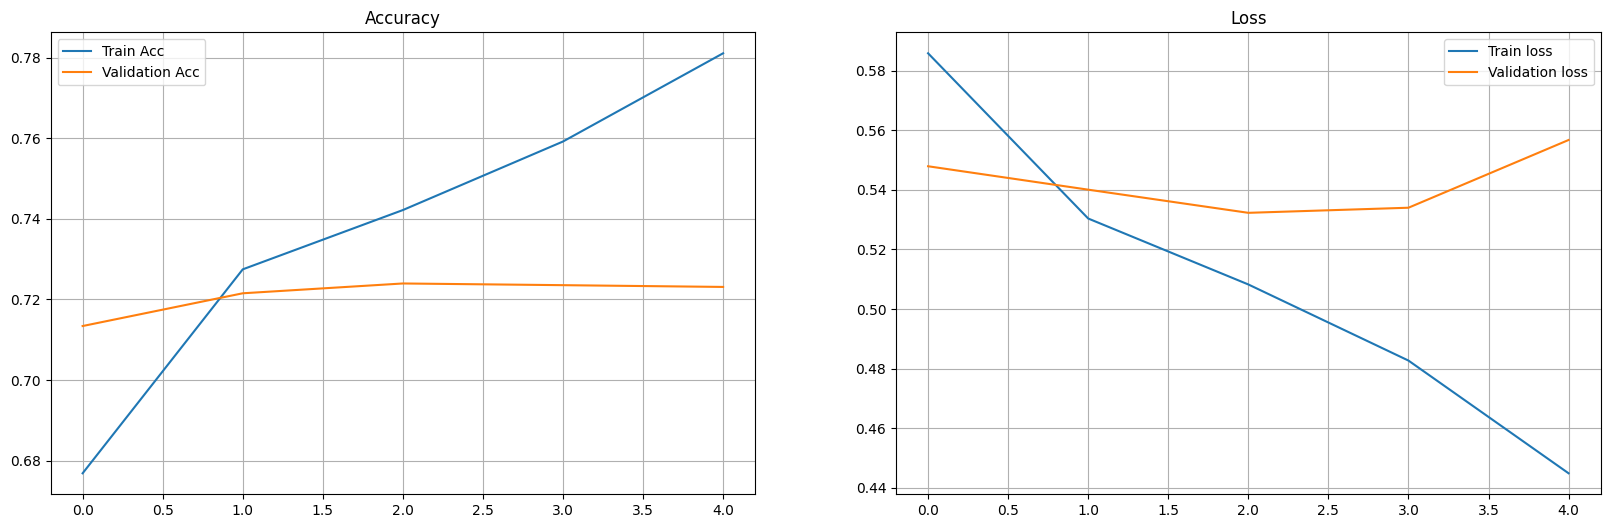

In [170]:
classifier.plot_performance_curves()


##### 9.4 Use the trained model to make predictions on unseen data

In [167]:
trial_news_review_sentiment_indexes = [10, 25, 30, 40, 45]
report_divider = '='*70
for index in trial_news_review_sentiment_indexes:
  classifier.predict_news_review_sentiment(index, X_test, y_test)
  print(f"\n\n{report_divider}")

The sentiment review of index => 10 is:
Next 6 months likely to be  stagnant  but lot of small & midcaps can could double : Satish Kumar

Expected sentiment is: negative
Predicted sentiment is: negative

Probability of the prediction is: 0.8948447182774544

**************************************************


The sentiment review of index => 25 is:
MSME day 2019 : Access to credit , technology adoption , connect with global peers , key for Indian MSMEs growth : WASME

Expected sentiment is: positive
Predicted sentiment is: positive

Probability of the prediction is: 0.9793158173561096

**************************************************


The sentiment review of index => 30 is:
Inflation : World stocks hit record high as bond yields ease with inflation fears

Expected sentiment is: positive
Predicted sentiment is: negative

Probability of the prediction is: 0.7123355567455292

**************************************************


The sentiment review of index => 40 is:
Indian Ocean : Aus

#####

##### 10. Demo findings
- 10.1 Classification Report of the reviews sentiment prediction (validation dataset)
- 10.2 Confusion Matrix of the reviews sentiment prediction (validation dataset)
- 10.3 Improvement suggestions

##### 10.1 Classification Report of the reviews sentiment prediction (validation dataset)

In [168]:
classifier.compute_validation_classification_report()

Validation Classification Report:
              precision    recall  f1-score   support

    Negative       0.74      0.74      0.74    153942
    Positive       0.70      0.70      0.70    131498

    accuracy                           0.72    285440
   macro avg       0.72      0.72      0.72    285440
weighted avg       0.72      0.72      0.72    285440



##### 10.2 Confusion Matrix of the reviews sentiment prediction (validation dataset)

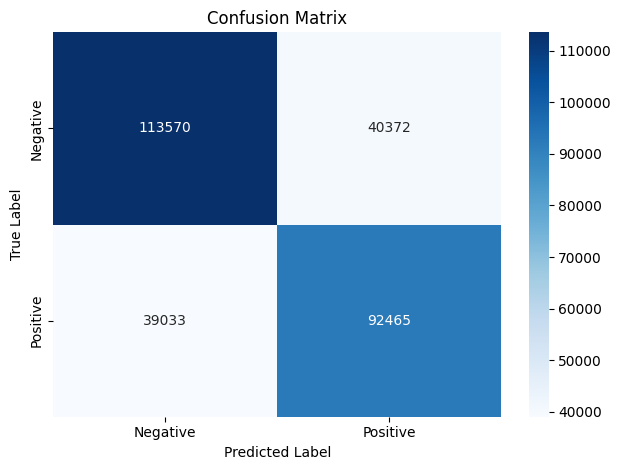

In [169]:
classifier.compute_validation_confusion_matrix()

##### 10.3 Improvement suggestions
Some improvement suggestions are as follow:

* Do further model training by experimenting with the configurations:
  * Running a hyperparameter search to optimize your configurations.
* Using pretraned word embeddings like Glove word embeddings
* Increasing the model complexity like adding more layers/ using bidirectional LSTMs
